In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import trimesh
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import os
import random
from copy import copy
import h5py
from tqdm.auto import tqdm

/home/xingchenliu/anaconda3/envs/torch/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset:

In [2]:
#borrow from https://github.com/luost26/diffusion-point-cloud/blob/1e30d48d018820fbc7c67c8b3190215bd41878e4/utils/dataset.py

synsetid_to_cate = {
    '02691156': 'airplane', '02773838': 'bag', '02801938': 'basket',
    '02808440': 'bathtub', '02818832': 'bed', '02828884': 'bench',
    '02876657': 'bottle', '02880940': 'bowl', '02924116': 'bus',
    '02933112': 'cabinet', '02747177': 'can', '02942699': 'camera',
    '02954340': 'cap', '02958343': 'car', '03001627': 'chair',
    '03046257': 'clock', '03207941': 'dishwasher', '03211117': 'monitor',
    '04379243': 'table', '04401088': 'telephone', '02946921': 'tin_can',
    '04460130': 'tower', '04468005': 'train', '03085013': 'keyboard',
    '03261776': 'earphone', '03325088': 'faucet', '03337140': 'file',
    '03467517': 'guitar', '03513137': 'helmet', '03593526': 'jar',
    '03624134': 'knife', '03636649': 'lamp', '03642806': 'laptop',
    '03691459': 'speaker', '03710193': 'mailbox', '03759954': 'microphone',
    '03761084': 'microwave', '03790512': 'motorcycle', '03797390': 'mug',
    '03928116': 'piano', '03938244': 'pillow', '03948459': 'pistol',
    '03991062': 'pot', '04004475': 'printer', '04074963': 'remote_control',
    '04090263': 'rifle', '04099429': 'rocket', '04225987': 'skateboard',
    '04256520': 'sofa', '04330267': 'stove', '04530566': 'vessel',
    '04554684': 'washer', '02992529': 'cellphone',
    '02843684': 'birdhouse', '02871439': 'bookshelf',
    # '02858304': 'boat', no boat in our dataset, merged into vessels
    # '02834778': 'bicycle', not in our taxonomy
}
cate_to_synsetid = {v: k for k, v in synsetid_to_cate.items()}


class ShapeNetCore(Dataset):

    GRAVITATIONAL_AXIS = 1
    
    def __init__(self, path, cates, split, scale_mode, transform=None):
        super().__init__()
        assert isinstance(cates, list), '`cates` must be a list of cate names.'
        assert split in ('train', 'val', 'test')
        assert scale_mode is None or scale_mode in ('global_unit', 'shape_unit', 'shape_bbox', 'shape_half', 'shape_34')
        self.path = path
        if 'all' in cates:
            cates = cate_to_synsetid.keys()
        self.cate_synsetids = [cate_to_synsetid[s] for s in cates]
        self.cate_synsetids.sort()
        self.split = split
        self.scale_mode = scale_mode
        self.transform = transform

        self.pointclouds = []
        self.stats = None

        self.get_statistics()
        self.load()

    def get_statistics(self):

        basename = os.path.basename(self.path)
        dsetname = basename[:basename.rfind('.')]
        stats_dir = os.path.join(os.path.dirname(self.path), dsetname + '_stats')
        os.makedirs(stats_dir, exist_ok=True)

        if len(self.cate_synsetids) == len(cate_to_synsetid):
            stats_save_path = os.path.join(stats_dir, 'stats_all.pt')
        else:
            stats_save_path = os.path.join(stats_dir, 'stats_' + '_'.join(self.cate_synsetids) + '.pt')
        if os.path.exists(stats_save_path):
            self.stats = torch.load(stats_save_path)
            return self.stats

        with h5py.File(self.path, 'r') as f:
            pointclouds = []
            for synsetid in self.cate_synsetids:
                for split in ('train', 'val', 'test'):
                    pointclouds.append(torch.from_numpy(f[synsetid][split][...]))

        all_points = torch.cat(pointclouds, dim=0) # (B, N, 3)
        B, N, _ = all_points.size()
        mean = all_points.view(B*N, -1).mean(dim=0) # (1, 3)
        std = all_points.view(-1).std(dim=0)        # (1, )

        self.stats = {'mean': mean, 'std': std}
        torch.save(self.stats, stats_save_path)
        return self.stats

    def load(self):

        def _enumerate_pointclouds(f):
            for synsetid in self.cate_synsetids:
                cate_name = synsetid_to_cate[synsetid]
                for j, pc in enumerate(f[synsetid][self.split]):
                    yield torch.from_numpy(pc), j, cate_name
        
        with h5py.File(self.path, mode='r') as f:
            for pc, pc_id, cate_name in _enumerate_pointclouds(f):

                if self.scale_mode == 'global_unit':
                    shift = pc.mean(dim=0).reshape(1, 3)
                    scale = self.stats['std'].reshape(1, 1)
                elif self.scale_mode == 'shape_unit':
                    shift = pc.mean(dim=0).reshape(1, 3)
                    scale = pc.flatten().std().reshape(1, 1)
                elif self.scale_mode == 'shape_half':
                    shift = pc.mean(dim=0).reshape(1, 3)
                    scale = pc.flatten().std().reshape(1, 1) / (0.5)
                elif self.scale_mode == 'shape_34':
                    shift = pc.mean(dim=0).reshape(1, 3)
                    scale = pc.flatten().std().reshape(1, 1) / (0.75)
                elif self.scale_mode == 'shape_bbox':
                    pc_max, _ = pc.max(dim=0, keepdim=True) # (1, 3)
                    pc_min, _ = pc.min(dim=0, keepdim=True) # (1, 3)
                    shift = ((pc_min + pc_max) / 2).view(1, 3)
                    scale = (pc_max - pc_min).max().reshape(1, 1) / 2
                else:
                    shift = torch.zeros([1, 3])
                    scale = torch.ones([1, 1])

                pc = (pc - shift) / scale

                self.pointclouds.append({
                    'pointcloud': pc,
                    'cate': cate_name,
                    'id': pc_id,
                    'shift': shift,
                    'scale': scale
                })

        # Deterministically shuffle the dataset
        self.pointclouds.sort(key=lambda data: data['id'], reverse=False)
        random.Random(2020).shuffle(self.pointclouds)

    def __len__(self):
        return len(self.pointclouds)

    def __getitem__(self, idx):
        data = {k:v.clone() if isinstance(v, torch.Tensor) else copy(v) for k, v in self.pointclouds[idx].items()}
        if self.transform is not None:
            data = self.transform(data)
        return data

In [3]:
#https://github.com/luost26/diffusion-point-cloud/blob/1e30d48d018820fbc7c67c8b3190215bd41878e4/utils/data.py
def get_train_val_test_datasets(dataset, train_ratio, val_ratio):
    assert (train_ratio + val_ratio) <= 1
    train_size = int(len(dataset) * train_ratio)
    val_size = int(len(dataset) * val_ratio)
    test_size = len(dataset) - train_size - val_size
    
    train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])
    return train_set, val_set, test_set


def get_train_val_test_loaders(dataset, train_ratio, val_ratio, train_batch_size, val_test_batch_size, num_workers):
    train_set, val_set, test_set = get_train_val_test_datasets(dataset, train_ratio, val_ratio)

    train_loader = DataLoader(train_set, train_batch_size, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_set, val_test_batch_size, shuffle=False, num_workers=num_workers)
    test_loader = DataLoader(test_set, val_test_batch_size, shuffle=False, num_workers=num_workers)
    
    return train_loader, val_loader, test_loader


def get_data_iterator(iterable):
    """Allows training with DataLoaders in a single infinite loop:
        for i, data in enumerate(inf_generator(train_loader)):
    """
    iterator = iterable.__iter__()
    while True:
        try:
            yield iterator.__next__()
        except StopIteration:
            iterator = iterable.__iter__()

In [4]:
# Parameters
path_to_shapenet = "data/shapenet.hdf5"
categories = ['airplane']  # Use the categories you're interested in
scale_mode = 'shape_unit'  # or whichever scale mode you want to use
train_batch_size = 128
val_batch_size = 128
num_workers = 0

# Transform
transform = None
# Uncomment and replace with your own transform if needed.
# Example: transform = RandomRotate(180, ['pointcloud'], axis=1)

# Datasets and loaders
train_dset = ShapeNetCore(
    path=path_to_shapenet,
    cates=categories,
    split='train',
    scale_mode=scale_mode,
    transform=transform,
)
val_dset = ShapeNetCore(
    path=path_to_shapenet,
    cates=categories,
    split='val',
    scale_mode=scale_mode,
    transform=transform,
)

# Note: The original code uses get_data_iterator, which allows for an infinite loop.
# If you don't want an infinite loop, simply use DataLoader directly as shown below.
train_loader = DataLoader(train_dset, batch_size=train_batch_size, num_workers=num_workers)
val_loader = DataLoader(val_dset, batch_size=val_batch_size, num_workers=num_workers)

# If you want the infinite loop, use get_data_iterator instead:
# train_iter = get_data_iterator(train_loader)

Visualize the dataset

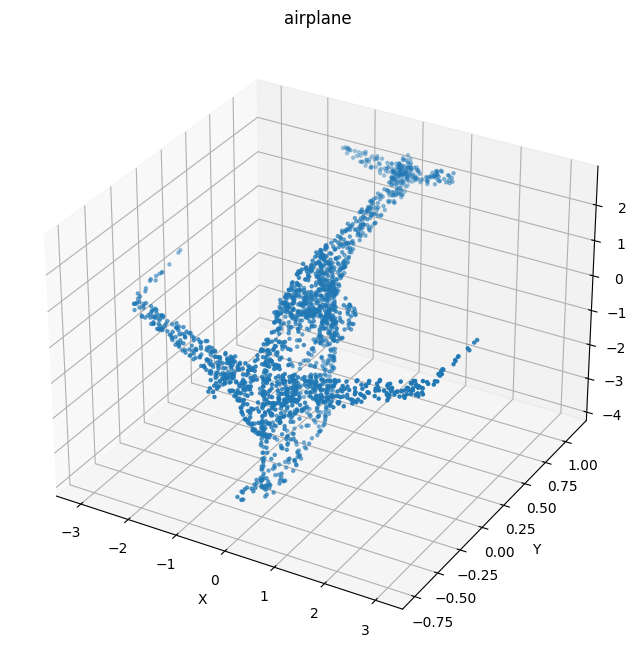

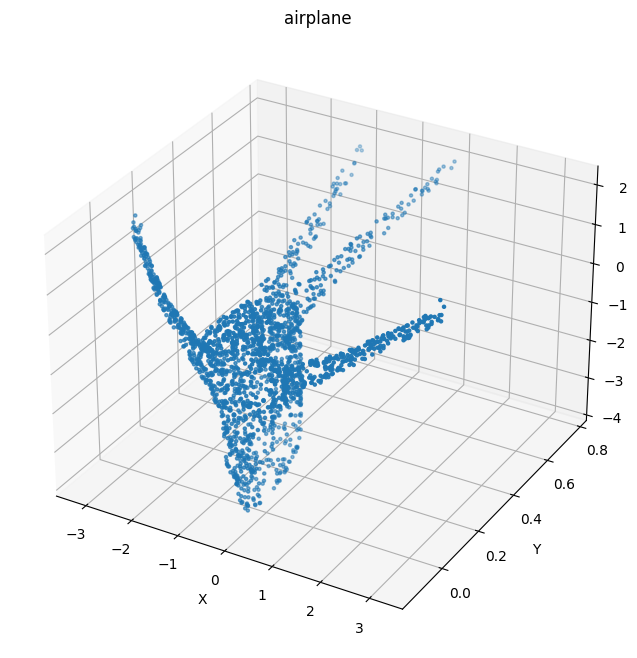

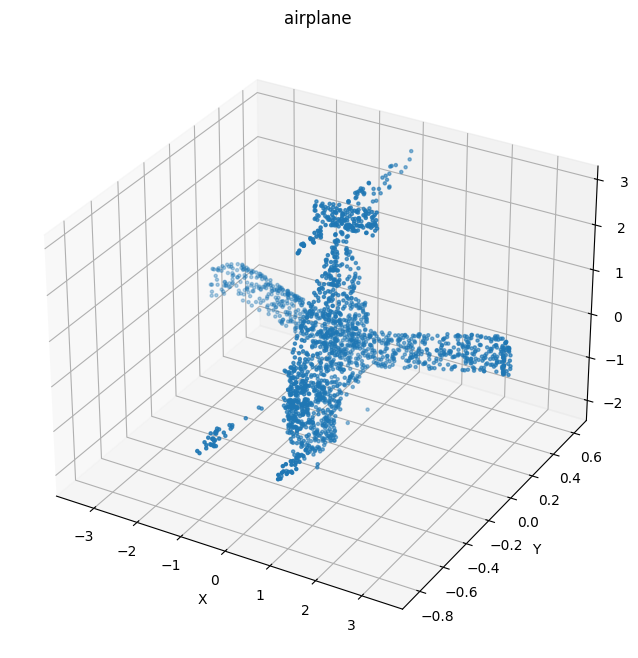

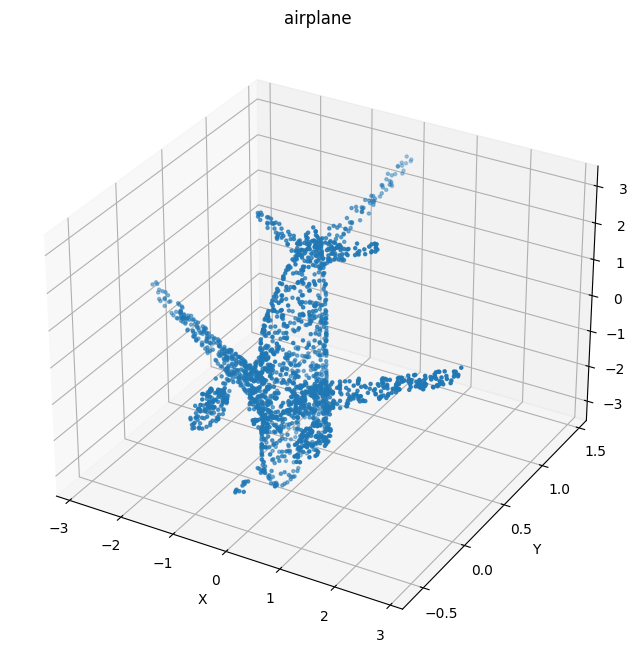

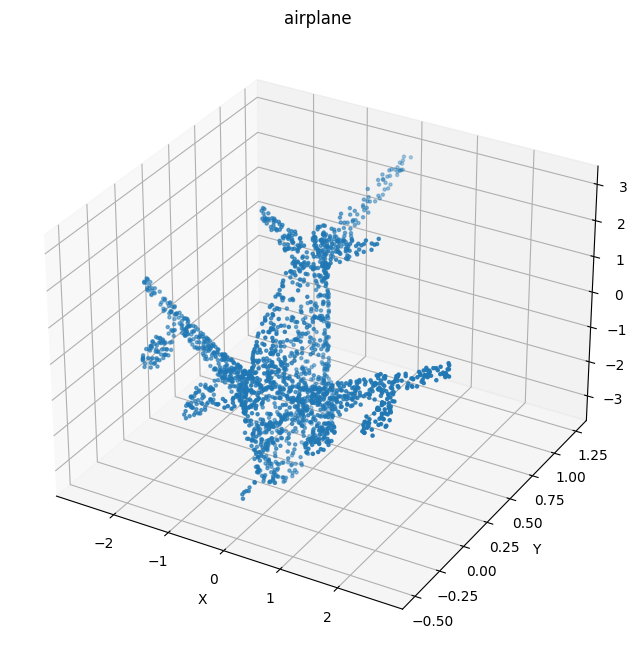

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_pointcloud(points, title=""):
    """Visualize a single point cloud."""
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=5)
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    ax.set_title(title)
    plt.show()

def visualize_dataset(dataset, num_samples=5):
    """Visualize random samples from the dataset."""
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    for idx in indices:
        sample = dataset[idx]
        points = sample['pointcloud'].numpy()
        title = sample['cate']
        visualize_pointcloud(points, title=title)

# Usage:
visualize_dataset(train_dset)

Encoder:

In [6]:
class TransformNet(nn.Module):
    def __init__(self, k=3):
        super(TransformNet, self).__init__()
        
        # Layers
        self.conv1 = nn.Conv1d(k, 64, 1)
        self.conv2 = nn.Conv1d(64, 128, 1)
        self.conv3 = nn.Conv1d(128, 1024, 1)
        
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, k*k)  # k*k for transformation matrix
        
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)
        
        # Initialize the weights/bias with Identity transformation
        self.fc3.weight.data.zero_()
        self.fc3.bias.data.copy_(torch.eye(k).view(-1))

    def forward(self, x):
        batch_size = x.size(0)
        
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)
        
        x = F.relu(self.bn4(self.fc1(x)))
        x = F.relu(self.bn5(self.fc2(x)))
        
        x = self.fc3(x)
        
        # Reshape to the transformation matrix
        x = x.view(batch_size, -1)
        iden = torch.eye(self.fc3.out_features // x.size(-1)).view(-1).to(x.device)
        x = x + iden
        x = x.view(batch_size, x.size(1) // int(x.size(1)**0.5), int(x.size(1)**0.5))
        
        return x

In [7]:
class VariationalPointNetEncoder(nn.Module):
    def __init__(self, num_points=2048, latent_size=256):
        super(VariationalPointNetEncoder, self).__init__()
        
        # Input transform
        self.input_transform = TransformNet(k=3)
        
        # Shared MLP
        self.conv1 = nn.Conv1d(3, 64, 1)
        self.conv2 = nn.Conv1d(64, 128, 1)
        self.conv3 = nn.Conv1d(128, 1024, 1)
        
        # Feature transform
        self.feature_transform = TransformNet(k=64)
        
        # Batch Norm layers
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        
        # Transition layers before latent space calculation
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        
        # For mu and log variance
        self.fc_mu = nn.Linear(256, latent_size)
        self.fc_log_var = nn.Linear(256, latent_size)
        
        # Normal distribution and KL divergence
        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda()
        self.N.scale = self.N.scale.cuda()
        self.kl = 0

    def forward(self, x):
        x = x.transpose(2, 1)
        
        # Apply input transform
        input_transform = self.input_transform(x)
        x = torch.bmm(x.transpose(1, 2), input_transform).transpose(1, 2)

        
        # Shared MLP layers
        x = F.relu(self.bn1(self.conv1(x)))
        
        # Apply feature transform
        feature_transform = self.feature_transform(x)
        x = torch.bmm(x.transpose(1, 2), feature_transform).transpose(1, 2)

        
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        
        # Global max pooling
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)
        
        # Transition layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        # Get mu and log variance
        mu = self.fc_mu(x)
        log_var = self.fc_log_var(x)
        
        # Reparametrization trick
        sigma = torch.exp(0.5 * log_var)
        z = mu + sigma * self.N.sample(mu.shape)
        
        # KL divergence
        self.kl = (0.5 * (sigma**2 + mu**2 - log_var - 1)).sum()
        
        return z


Decoder:

In [8]:
class PointNetDecoder(nn.Module):
    def __init__(self, num_points=2048, latent_size=256):
        super(PointNetDecoder, self).__init__()
        
        self.num_points = num_points
        
        # More expressive layers
        self.fc1 = nn.Linear(latent_size, 512)
        self.fc2 = nn.Linear(512, 1024)
        self.fc3 = nn.Linear(1024, 1024)
        self.fc4 = nn.Linear(1024, num_points * 3)
        
        self.dropout = nn.Dropout(p=0.4)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        
        return x.view(-1, self.num_points, 3)


VAE

In [9]:
class PointCloudVAE(nn.Module):
    def __init__(self, num_points=2048, latent_size=256):
        super(PointCloudVAE, self).__init__()
        
        # Using the VariationalPointNetEncoder
        self.encoder = VariationalPointNetEncoder(num_points=num_points, latent_size=latent_size)
        self.decoder = PointNetDecoder(num_points=num_points, latent_size=latent_size)

    def forward(self, x):
        # Encode input point cloud and get latent variable z
        z = self.encoder(x)
        
        # Decode z to get the reconstructed point cloud
        reconstructed = self.decoder(z)
        
        return reconstructed, self.encoder.kl

# The vae_loss function needs to be updated since we won't have mu and logvar separately
def vae_loss(reconstructed, original, kl_div, beta=1.0):
    # Reconstruction loss
    recon_loss = F.mse_loss(reconstructed, original, reduction='sum')
    
    # Return combined loss
    return recon_loss + beta * kl_div

# Usage remains largely the same:

# Create a VAE
vae = PointCloudVAE(num_points=2048, latent_size=256)

# Forward pass would now look something like this:
# reconstructed, kl_div = vae(point_cloud)

# Compute loss
# loss = vae_loss(reconstructed, point_cloud, kl_div)


Train

In [10]:
def train_vae(model, train_loader, val_loader, optimizer, epochs=100, device='cuda'):
    """
    Trains the VAE model.
    """
    model.to(device)
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        
        # Training
        for batch in tqdm(train_loader):
            point_clouds = batch['pointcloud'].to(device)
            
            optimizer.zero_grad()
            reconstructed, kl_div = model(point_clouds)
            
            loss = vae_loss(reconstructed, point_clouds, kl_div)
            loss.backward()
            
            train_loss += loss.item()
            optimizer.step()
            
        avg_train_loss = train_loss / len(train_loader.dataset)
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                point_clouds = batch['pointcloud'].to(device)
                reconstructed, kl_div = model(point_clouds)
                loss = vae_loss(reconstructed, point_clouds, kl_div)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader.dataset)
        
        print(f"Epoch: {epoch+1}, Avg Train Loss: {avg_train_loss:.4f}, Avg Val Loss: {avg_val_loss:.4f}")


In [11]:
vae = PointCloudVAE()
optimizer = torch.optim.Adam(vae.parameters(), lr=0.001, weight_decay=0)

In [12]:
train_vae(vae, train_loader, val_loader, optimizer)

100%|██████████| 27/27 [00:03<00:00,  8.77it/s]


Epoch: 1, Avg Train Loss: 5682.4885, Avg Val Loss: 5662.8012


100%|██████████| 27/27 [00:02<00:00, 10.53it/s]


Epoch: 2, Avg Train Loss: 5676.3156, Avg Val Loss: 5662.1521


100%|██████████| 27/27 [00:02<00:00, 10.53it/s]


Epoch: 3, Avg Train Loss: 5675.6220, Avg Val Loss: 5661.9504


100%|██████████| 27/27 [00:02<00:00, 10.55it/s]


Epoch: 4, Avg Train Loss: 5675.2762, Avg Val Loss: 5661.9132


100%|██████████| 27/27 [00:02<00:00, 10.56it/s]


Epoch: 5, Avg Train Loss: 5675.0377, Avg Val Loss: 5661.9286


100%|██████████| 27/27 [00:02<00:00, 10.53it/s]


Epoch: 6, Avg Train Loss: 5674.9017, Avg Val Loss: 5661.9686


100%|██████████| 27/27 [00:02<00:00, 10.54it/s]


Epoch: 7, Avg Train Loss: 5674.8197, Avg Val Loss: 5662.0107


100%|██████████| 27/27 [00:02<00:00, 10.54it/s]


Epoch: 8, Avg Train Loss: 5674.7505, Avg Val Loss: 5662.0628


100%|██████████| 27/27 [00:02<00:00, 10.54it/s]


Epoch: 9, Avg Train Loss: 5674.7054, Avg Val Loss: 5662.1099


100%|██████████| 27/27 [00:02<00:00, 10.53it/s]


Epoch: 10, Avg Train Loss: 5674.6754, Avg Val Loss: 5662.1525


100%|██████████| 27/27 [00:02<00:00, 10.53it/s]


Epoch: 11, Avg Train Loss: 5674.6597, Avg Val Loss: 5662.1886


100%|██████████| 27/27 [00:02<00:00, 10.53it/s]


Epoch: 12, Avg Train Loss: 5674.6566, Avg Val Loss: 5662.2187


100%|██████████| 27/27 [00:02<00:00, 10.61it/s]


Epoch: 13, Avg Train Loss: 5674.6441, Avg Val Loss: 5662.2408


100%|██████████| 27/27 [00:02<00:00, 10.62it/s]


Epoch: 14, Avg Train Loss: 5674.6437, Avg Val Loss: 5662.2605


100%|██████████| 27/27 [00:02<00:00, 10.62it/s]


Epoch: 15, Avg Train Loss: 5674.6404, Avg Val Loss: 5662.2778


100%|██████████| 27/27 [00:02<00:00, 10.62it/s]


Epoch: 16, Avg Train Loss: 5674.6530, Avg Val Loss: 5662.2893


100%|██████████| 27/27 [00:02<00:00, 10.61it/s]


Epoch: 17, Avg Train Loss: 5674.6351, Avg Val Loss: 5662.2966


100%|██████████| 27/27 [00:02<00:00, 10.62it/s]


Epoch: 18, Avg Train Loss: 5674.6386, Avg Val Loss: 5662.3024


100%|██████████| 27/27 [00:02<00:00, 10.62it/s]


Epoch: 19, Avg Train Loss: 5674.6376, Avg Val Loss: 5662.3084


100%|██████████| 27/27 [00:02<00:00, 10.62it/s]


Epoch: 20, Avg Train Loss: 5674.6315, Avg Val Loss: 5662.3129


100%|██████████| 27/27 [00:02<00:00, 10.62it/s]


Epoch: 21, Avg Train Loss: 5674.6361, Avg Val Loss: 5662.3161


100%|██████████| 27/27 [00:02<00:00, 10.62it/s]


Epoch: 22, Avg Train Loss: 5674.6327, Avg Val Loss: 5662.3196


100%|██████████| 27/27 [00:02<00:00, 10.62it/s]


Epoch: 23, Avg Train Loss: 5674.6323, Avg Val Loss: 5662.3215


100%|██████████| 27/27 [00:02<00:00, 10.62it/s]


Epoch: 24, Avg Train Loss: 5674.6335, Avg Val Loss: 5662.3234


100%|██████████| 27/27 [00:02<00:00, 10.63it/s]


Epoch: 25, Avg Train Loss: 5674.6316, Avg Val Loss: 5662.3250


100%|██████████| 27/27 [00:02<00:00, 10.62it/s]


Epoch: 26, Avg Train Loss: 5674.6353, Avg Val Loss: 5662.3264


100%|██████████| 27/27 [00:02<00:00, 10.63it/s]


Epoch: 27, Avg Train Loss: 5674.6315, Avg Val Loss: 5662.3282


100%|██████████| 27/27 [00:02<00:00, 10.62it/s]


Epoch: 28, Avg Train Loss: 5674.6374, Avg Val Loss: 5662.3279


100%|██████████| 27/27 [00:02<00:00, 10.62it/s]


Epoch: 29, Avg Train Loss: 5674.6330, Avg Val Loss: 5662.3282


100%|██████████| 27/27 [00:02<00:00, 10.62it/s]


Epoch: 30, Avg Train Loss: 5674.6317, Avg Val Loss: 5662.3298


100%|██████████| 27/27 [00:02<00:00, 10.62it/s]


Epoch: 31, Avg Train Loss: 5674.6334, Avg Val Loss: 5662.3294


100%|██████████| 27/27 [00:02<00:00, 10.62it/s]


Epoch: 32, Avg Train Loss: 5674.6333, Avg Val Loss: 5662.3296


100%|██████████| 27/27 [00:02<00:00, 10.62it/s]


Epoch: 33, Avg Train Loss: 5674.6322, Avg Val Loss: 5662.3298


100%|██████████| 27/27 [00:02<00:00, 10.62it/s]


Epoch: 34, Avg Train Loss: 5674.6325, Avg Val Loss: 5662.3301


100%|██████████| 27/27 [00:02<00:00, 10.62it/s]


Epoch: 35, Avg Train Loss: 5674.6323, Avg Val Loss: 5662.3303


100%|██████████| 27/27 [00:02<00:00, 10.62it/s]


Epoch: 36, Avg Train Loss: 5674.6323, Avg Val Loss: 5662.3305


100%|██████████| 27/27 [00:02<00:00, 10.62it/s]


Epoch: 37, Avg Train Loss: 5674.6324, Avg Val Loss: 5662.3311


100%|██████████| 27/27 [00:02<00:00, 10.62it/s]


Epoch: 38, Avg Train Loss: 5674.6323, Avg Val Loss: 5662.3307


100%|██████████| 27/27 [00:02<00:00, 10.62it/s]


Epoch: 39, Avg Train Loss: 5674.6329, Avg Val Loss: 5662.3311


100%|██████████| 27/27 [00:02<00:00, 10.62it/s]


Epoch: 40, Avg Train Loss: 5674.6340, Avg Val Loss: 5662.3305


100%|██████████| 27/27 [00:02<00:00, 10.62it/s]


Epoch: 41, Avg Train Loss: 5674.6340, Avg Val Loss: 5662.3328


100%|██████████| 27/27 [00:02<00:00, 10.61it/s]


Epoch: 42, Avg Train Loss: 5674.6333, Avg Val Loss: 5662.3309


100%|██████████| 27/27 [00:02<00:00, 10.62it/s]


Epoch: 43, Avg Train Loss: 5674.6332, Avg Val Loss: 5662.3315


100%|██████████| 27/27 [00:02<00:00, 10.62it/s]


Epoch: 44, Avg Train Loss: 5674.6328, Avg Val Loss: 5662.3306


100%|██████████| 27/27 [00:02<00:00, 10.62it/s]


Epoch: 45, Avg Train Loss: 5674.6351, Avg Val Loss: 5662.3311


100%|██████████| 27/27 [00:02<00:00, 10.63it/s]


Epoch: 46, Avg Train Loss: 5674.6324, Avg Val Loss: 5662.3305


100%|██████████| 27/27 [00:02<00:00, 10.62it/s]


Epoch: 47, Avg Train Loss: 5674.6325, Avg Val Loss: 5662.3308


100%|██████████| 27/27 [00:02<00:00, 10.61it/s]


Epoch: 48, Avg Train Loss: 5674.6401, Avg Val Loss: 5662.3305


100%|██████████| 27/27 [00:02<00:00, 10.62it/s]


Epoch: 49, Avg Train Loss: 5674.6321, Avg Val Loss: 5662.3304


100%|██████████| 27/27 [00:02<00:00, 10.62it/s]


Epoch: 50, Avg Train Loss: 5674.6336, Avg Val Loss: 5662.3306


100%|██████████| 27/27 [00:02<00:00, 10.62it/s]


Epoch: 51, Avg Train Loss: 5674.6326, Avg Val Loss: 5662.3307


100%|██████████| 27/27 [00:02<00:00, 10.62it/s]


Epoch: 52, Avg Train Loss: 5674.6328, Avg Val Loss: 5662.3307


100%|██████████| 27/27 [00:02<00:00, 10.62it/s]


Epoch: 53, Avg Train Loss: 5674.6326, Avg Val Loss: 5662.3310


100%|██████████| 27/27 [00:02<00:00, 10.62it/s]


Epoch: 54, Avg Train Loss: 5674.6438, Avg Val Loss: 5662.3301


100%|██████████| 27/27 [00:02<00:00, 10.62it/s]


Epoch: 55, Avg Train Loss: 5674.6326, Avg Val Loss: 5662.3299


100%|██████████| 27/27 [00:02<00:00, 10.62it/s]


Epoch: 56, Avg Train Loss: 5674.6370, Avg Val Loss: 5662.3298


100%|██████████| 27/27 [00:02<00:00, 10.62it/s]


Epoch: 57, Avg Train Loss: 5674.6329, Avg Val Loss: 5662.3303


100%|██████████| 27/27 [00:02<00:00, 10.61it/s]


Epoch: 58, Avg Train Loss: 5674.6324, Avg Val Loss: 5662.3306


100%|██████████| 27/27 [00:02<00:00, 10.62it/s]


Epoch: 59, Avg Train Loss: 5674.6322, Avg Val Loss: 5662.3310


100%|██████████| 27/27 [00:02<00:00, 10.61it/s]


Epoch: 60, Avg Train Loss: 5674.6321, Avg Val Loss: 5662.3306


100%|██████████| 27/27 [00:02<00:00, 10.62it/s]


Epoch: 61, Avg Train Loss: 5674.6325, Avg Val Loss: 5662.3306


100%|██████████| 27/27 [00:02<00:00, 10.63it/s]


Epoch: 62, Avg Train Loss: 5674.6321, Avg Val Loss: 5662.3307


100%|██████████| 27/27 [00:02<00:00, 10.62it/s]


Epoch: 63, Avg Train Loss: 5674.6319, Avg Val Loss: 5662.3307


100%|██████████| 27/27 [00:02<00:00, 10.62it/s]


Epoch: 64, Avg Train Loss: 5674.6335, Avg Val Loss: 5662.3309


100%|██████████| 27/27 [00:02<00:00, 10.62it/s]


Epoch: 65, Avg Train Loss: 5674.6323, Avg Val Loss: 5662.3312


100%|██████████| 27/27 [00:02<00:00, 10.62it/s]


Epoch: 66, Avg Train Loss: 5674.6322, Avg Val Loss: 5662.3308


100%|██████████| 27/27 [00:02<00:00, 10.62it/s]


Epoch: 67, Avg Train Loss: 5674.6332, Avg Val Loss: 5662.3313


100%|██████████| 27/27 [00:02<00:00, 10.62it/s]


Epoch: 68, Avg Train Loss: 5674.6324, Avg Val Loss: 5662.3310


100%|██████████| 27/27 [00:02<00:00, 10.62it/s]


Epoch: 69, Avg Train Loss: 5674.6347, Avg Val Loss: 5662.3321


100%|██████████| 27/27 [00:02<00:00, 10.62it/s]


Epoch: 70, Avg Train Loss: 5674.6326, Avg Val Loss: 5662.3310


100%|██████████| 27/27 [00:02<00:00, 10.62it/s]


Epoch: 71, Avg Train Loss: 5674.6327, Avg Val Loss: 5662.3310


100%|██████████| 27/27 [00:02<00:00, 10.62it/s]


Epoch: 72, Avg Train Loss: 5674.6345, Avg Val Loss: 5662.3311


100%|██████████| 27/27 [00:02<00:00, 10.62it/s]


Epoch: 73, Avg Train Loss: 5674.6327, Avg Val Loss: 5662.3307


100%|██████████| 27/27 [00:02<00:00, 10.62it/s]


Epoch: 74, Avg Train Loss: 5674.6328, Avg Val Loss: 5662.3308


100%|██████████| 27/27 [00:02<00:00, 10.62it/s]


Epoch: 75, Avg Train Loss: 5674.6321, Avg Val Loss: 5662.3312


100%|██████████| 27/27 [00:02<00:00, 10.60it/s]


Epoch: 76, Avg Train Loss: 5674.6326, Avg Val Loss: 5662.3307


100%|██████████| 27/27 [00:02<00:00, 10.61it/s]


Epoch: 77, Avg Train Loss: 5674.6324, Avg Val Loss: 5662.3312


100%|██████████| 27/27 [00:02<00:00, 10.61it/s]


Epoch: 78, Avg Train Loss: 5674.6322, Avg Val Loss: 5662.3309


100%|██████████| 27/27 [00:02<00:00, 10.61it/s]


Epoch: 79, Avg Train Loss: 5674.6325, Avg Val Loss: 5662.3309


100%|██████████| 27/27 [00:02<00:00, 10.62it/s]


Epoch: 80, Avg Train Loss: 5674.6320, Avg Val Loss: 5662.3308


100%|██████████| 27/27 [00:02<00:00, 10.61it/s]


Epoch: 81, Avg Train Loss: 5674.6325, Avg Val Loss: 5662.3308


100%|██████████| 27/27 [00:02<00:00, 10.61it/s]


Epoch: 82, Avg Train Loss: 5674.6323, Avg Val Loss: 5662.3309


100%|██████████| 27/27 [00:02<00:00, 10.62it/s]


Epoch: 83, Avg Train Loss: 5674.6331, Avg Val Loss: 5662.3314


100%|██████████| 27/27 [00:02<00:00, 10.62it/s]


Epoch: 84, Avg Train Loss: 5674.6326, Avg Val Loss: 5662.3325


100%|██████████| 27/27 [00:02<00:00, 10.61it/s]


Epoch: 85, Avg Train Loss: 5674.6328, Avg Val Loss: 5662.3309


100%|██████████| 27/27 [00:02<00:00, 10.61it/s]


Epoch: 86, Avg Train Loss: 5674.6328, Avg Val Loss: 5662.3305


100%|██████████| 27/27 [00:02<00:00, 10.61it/s]


Epoch: 87, Avg Train Loss: 5674.6336, Avg Val Loss: 5662.3310


100%|██████████| 27/27 [00:02<00:00, 10.61it/s]


Epoch: 88, Avg Train Loss: 5674.6337, Avg Val Loss: 5662.3308


100%|██████████| 27/27 [00:02<00:00, 10.62it/s]


Epoch: 89, Avg Train Loss: 5674.6334, Avg Val Loss: 5662.3309


100%|██████████| 27/27 [00:02<00:00, 10.62it/s]


Epoch: 90, Avg Train Loss: 5674.6345, Avg Val Loss: 5662.3305


100%|██████████| 27/27 [00:02<00:00, 10.61it/s]


Epoch: 91, Avg Train Loss: 5674.6352, Avg Val Loss: 5662.3304


100%|██████████| 27/27 [00:02<00:00, 10.61it/s]


Epoch: 92, Avg Train Loss: 5674.6391, Avg Val Loss: 5662.3305


100%|██████████| 27/27 [00:02<00:00, 10.61it/s]


Epoch: 93, Avg Train Loss: 5674.6329, Avg Val Loss: 5662.3304


100%|██████████| 27/27 [00:02<00:00, 10.61it/s]


Epoch: 94, Avg Train Loss: 5674.6324, Avg Val Loss: 5662.3307


100%|██████████| 27/27 [00:02<00:00, 10.61it/s]


Epoch: 95, Avg Train Loss: 5674.6345, Avg Val Loss: 5662.3307


100%|██████████| 27/27 [00:02<00:00, 10.61it/s]


Epoch: 96, Avg Train Loss: 5674.6336, Avg Val Loss: 5662.3312


100%|██████████| 27/27 [00:02<00:00, 10.62it/s]


Epoch: 97, Avg Train Loss: 5674.6332, Avg Val Loss: 5662.3311


100%|██████████| 27/27 [00:02<00:00, 10.61it/s]


Epoch: 98, Avg Train Loss: 5674.6329, Avg Val Loss: 5662.3307


100%|██████████| 27/27 [00:02<00:00, 10.61it/s]


Epoch: 99, Avg Train Loss: 5674.6324, Avg Val Loss: 5662.3307


100%|██████████| 27/27 [00:02<00:00, 10.60it/s]


Epoch: 100, Avg Train Loss: 5674.6368, Avg Val Loss: 5662.3308


Visualization

In [16]:
def validate_vae(model, val_loader, device='cuda'):
    """
    Validates the VAE model and returns the average validation loss.
    """
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            point_clouds = batch['pointcloud'].to(device)
            reconstructed, kl_div = model(point_clouds)
            loss = vae_loss(reconstructed, point_clouds, kl_div)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader.dataset)
    return avg_val_loss


In [17]:
def visualize_reconstruction(model, dataset, num_samples=5, device='cuda'):
    """
    Visualize the original and reconstructed point clouds side by side.
    """
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    model.eval()

    for idx in indices:
        sample = dataset[idx]
        points = sample['pointcloud'].unsqueeze(0).to(device)
        with torch.no_grad():
            reconstructed, _ = model(points)
        reconstructed = reconstructed.squeeze(0).cpu().numpy()
        points = points.squeeze(0).cpu().numpy()

        # Plotting
        fig = plt.figure(figsize=(15, 7))
        
        # Original point cloud
        ax1 = fig.add_subplot(121, projection='3d')
        ax1.scatter(points[:, 0], points[:, 1], points[:, 2], s=5)
        ax1.set_title("Original")
        
        # Reconstructed point cloud
        ax2 = fig.add_subplot(122, projection='3d')
        ax2.scatter(reconstructed[:, 0], reconstructed[:, 1], reconstructed[:, 2], s=5)
        ax2.set_title("Reconstructed")

        plt.show()


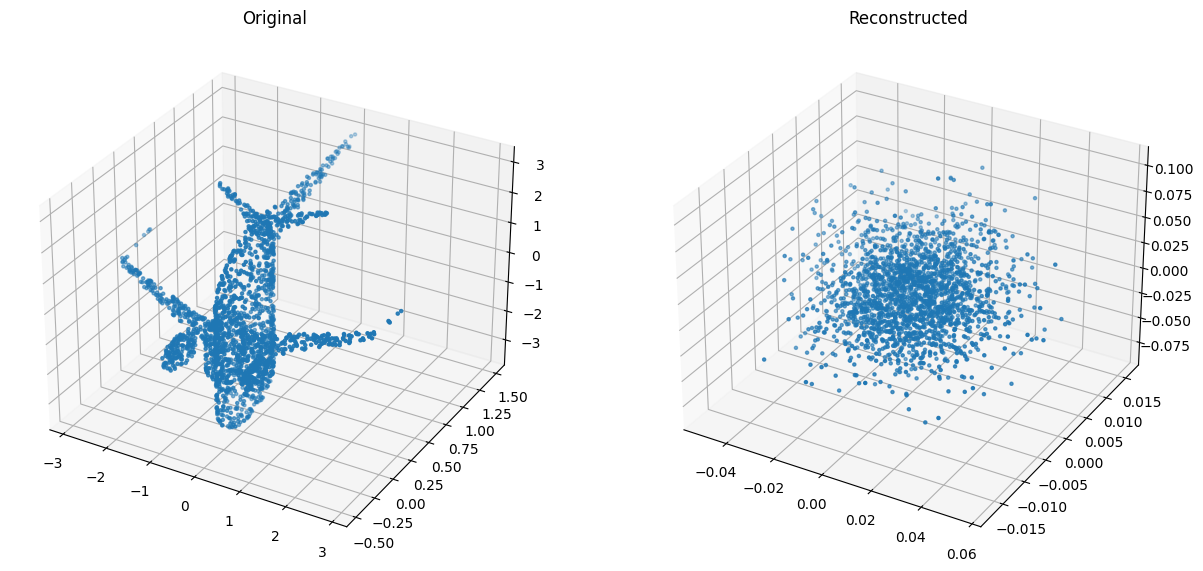

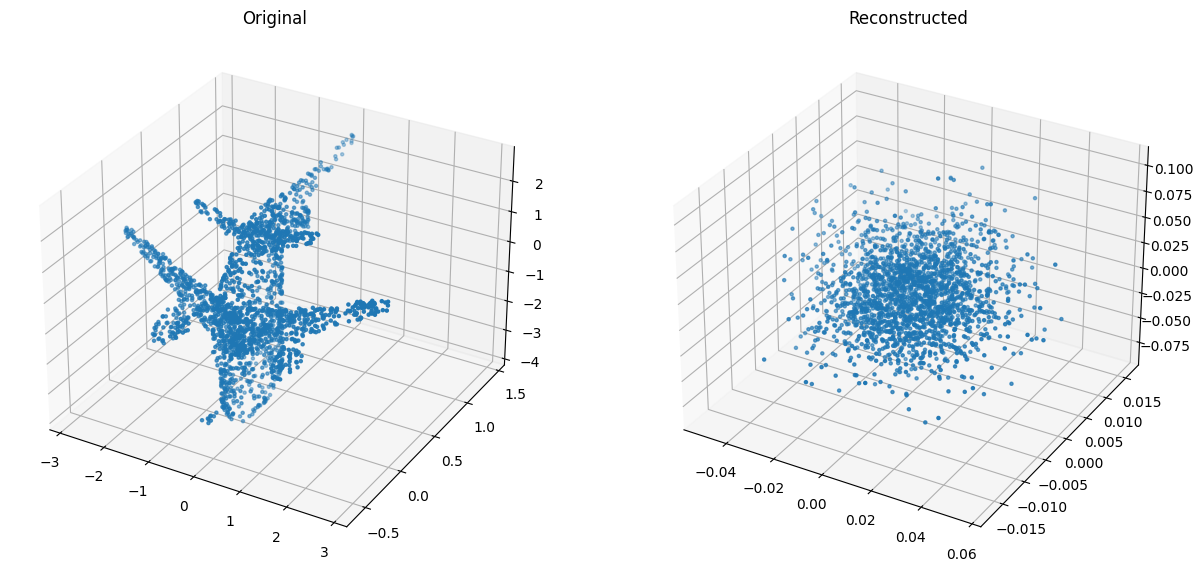

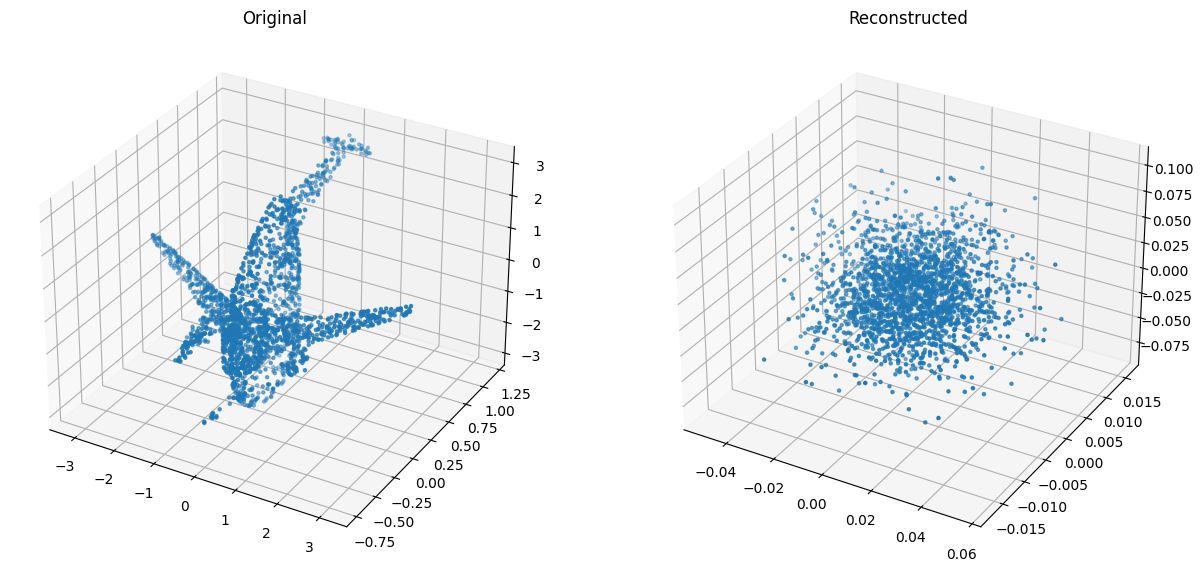

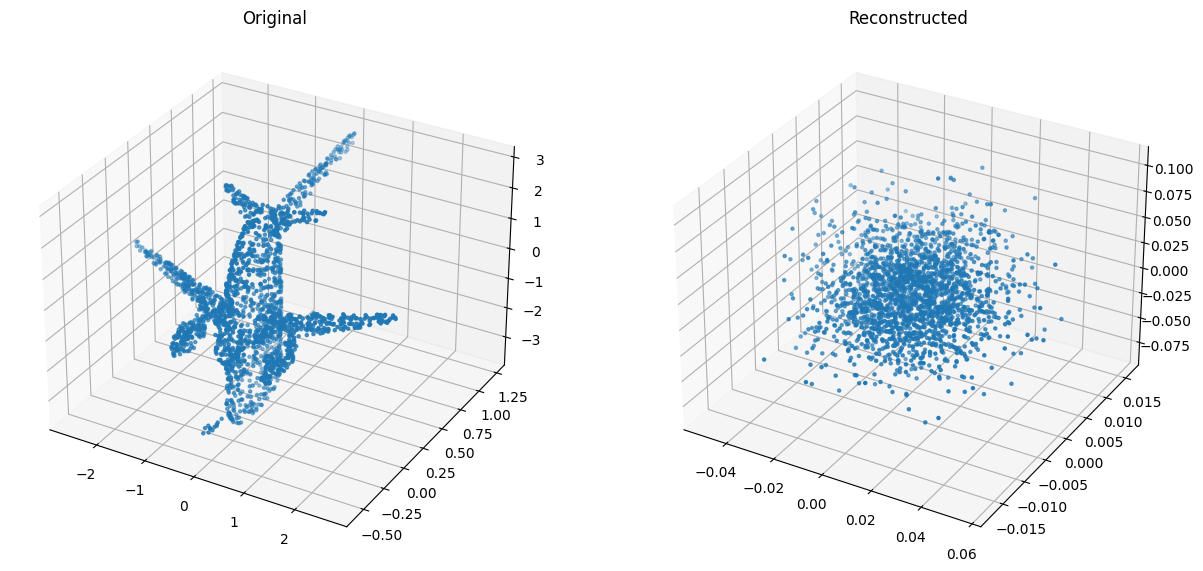

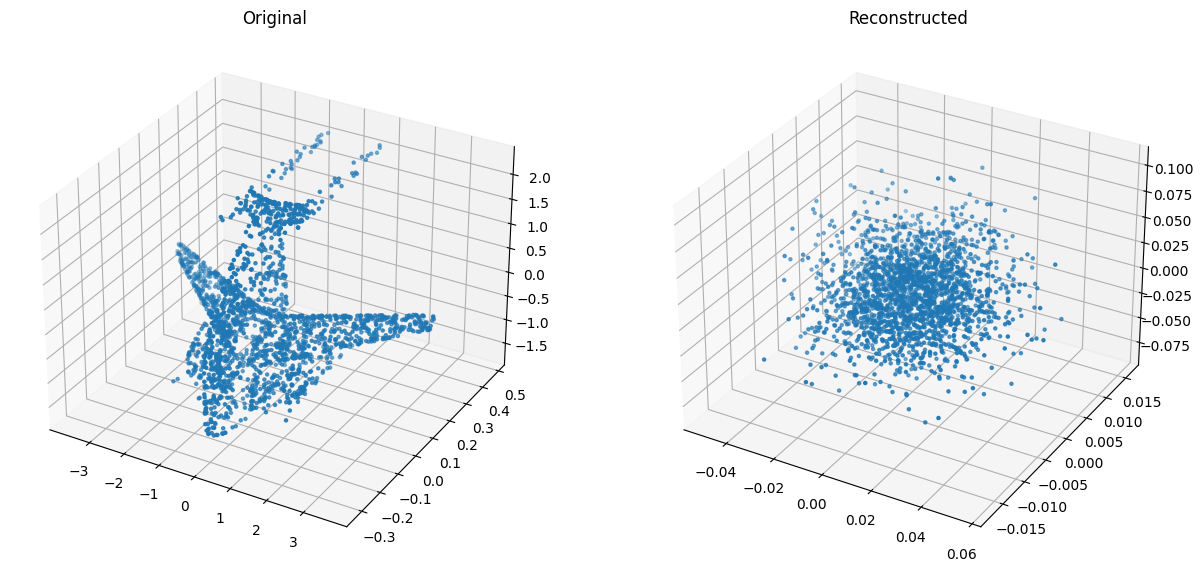

In [21]:
visualize_reconstruction(vae, val_dset)